In [ ]:
!pip install kaggle


In [ ]:
# Adding All the imports and modules that will be used.
import os # Used to write in API credentials
import zipfile # used to work with zip files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#importing data through api
!kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset


Dataset URL: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset
License(s): other
usa-real-estate-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# unzipping the dataset
import zipfile
with zipfile.ZipFile("usa-real-estate-dataset.zip", "r") as zip_ref:
    zip_ref.extractall()


In [ ]:
realestate = pd.read_csv("realtor-data.zip.csv")

In [ ]:
realestate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


In [ ]:
realestate.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [ ]:
# getting some prelimaerary information on the datasets
print(f'The dataframe has {realestate.shape[0]} rows and {realestate.shape[1]} columns.')


The dataframe has 2226382 rows and 12 columns.


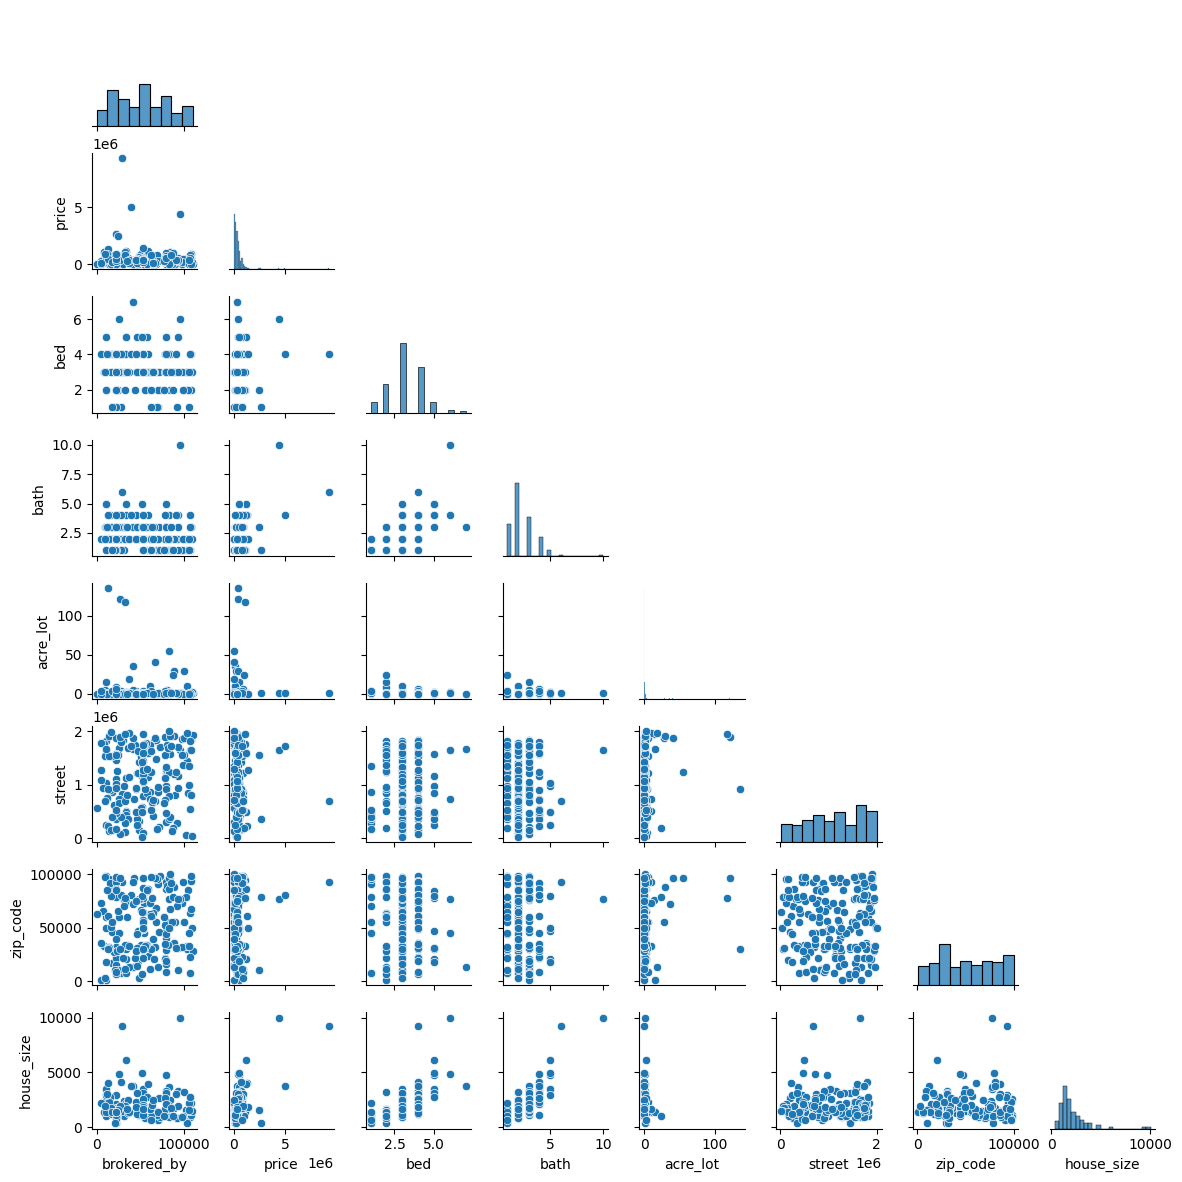

In [ ]:
sns.pairplot(realestate.sample(200),
             corner=True,
             kind='scatter',
             height=1.5)

In [ ]:
# checking for missing values and clearing them
realestate.isna().sum()

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64

In [ ]:
#convert brokered_by and street to str
realestate['brokered_by'] = realestate['brokered_by'].astype(str)
realestate['street'] = realestate['street'].astype(str)
#convert to datetime
realestate['prev_sold_date'] = pd.to_datetime(realestate['prev_sold_date'], errors='coerce')
#zip code to str so any zip codes that start with 0 won't get omitted
realestate['zip_code'] = realestate['zip_code'].astype(str)
print(realestate.dtypes)

brokered_by               object
status                    object
price                    float64
bed                      float64
bath                     float64
acre_lot                 float64
street                    object
city                      object
state                     object
zip_code                  object
house_size               float64
prev_sold_date    datetime64[ns]
dtype: object


In [ ]:
#drop rows that have small number of nulls
realestate.dropna(subset=['brokered_by', 'price', 'city', 'state'], inplace=True)

In [ ]:
#use median to fill in some numerical cols
# realestate['bed'].fillna(realestate['bed'].median(), inplace=True)
# realestate['bath'].fillna(realestate['bath'].median(), inplace=True)
# realestate['acre_lot'].fillna(realestate['acre_lot'].median(), inplace=True)
# realestate['house_size'].fillna(realestate['house_size'].median(), inplace=True)

In [ ]:
#I feel that since street is encoded anyways, and we have zip code and city, street col doesn't seem to give much info.
#drop street col
realestate.drop(columns=['street'],inplace=True)

In [ ]:
realestate = realestate[realestate['state'] != 'New Brunswick']

In [ ]:
#only get the rows that have a price of 10k or above
#10k seems to be the smallest number possible that's reasonable for a property in America
realestate = realestate[realestate['price'] >= 10000].reset_index(drop=True)

In [ ]:
#to clean city col, get rid of leading/trailing whitespace
realestate['city'] = realestate['city'].str.strip()

#different capitalization could also impact it, use title() so just the first letter of each word is capitalized
realestate['city'] = realestate['city'].str.title()

#get rid of any characters that don't belong, like numbers
realestate['city'] = realestate['city'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

In [ ]:
#we only want the 50 states, including DC, but get rid of puerto rico and virgin islands
realestate = realestate[(realestate['state'] != 'Puerto Rico') & (realestate['state'] != 'Virgin Islands')]

In [ ]:
# for prev_sold_date, latest date should be March 30, 2024, when this dataset was last updated
#get rid of any that's later than that
from datetime import datetime
realestate = realestate[realestate['prev_sold_date'] <= datetime(2024, 3, 30)]

In [ ]:
# want to keep prev_sold_date since it matters, but it has the most number of nulls
#worried that using something like mode/median to fill it in would introduce bias
#there doesn't seem to be a perfect way to deal with it for now
#however, since this dataset is so big, over 2.2 million rows, if all the null rows are dropped, I would still have a little over 1.4 million rows
#1.4 million rows should still be enough data to do analysis
#so drop all the null rows
realestate.dropna(subset=['prev_sold_date'], inplace=True)

In [ ]:
#bed, bath, acre_lot, and house_size also have a large number of nulls.
#considered using the median to fill it in, but thats 100s of thousands of rows that would be changed
#would probably skew the data a lot
#best thing to do now is to drop it all and work with what we have from there
#even dropping, all those null rows, we still have 1,089,458 rows to do analysis on
#still have a lot of data to work on, so maybe it's ok to just drop them all
realestate.dropna(subset=['bed','bath','acre_lot','house_size'], inplace=True)

In [ ]:
print(f'The dataframe (DF) has {realestate.shape[0]:,} rows and {realestate.shape[1]} features or columns.')

The dataframe (DF) has 1,089,183 rows and 11 features or columns.


In [ ]:
realestate.isnull().sum()

brokered_by       0
status            0
price             0
bed               0
bath              0
acre_lot          0
city              0
state             0
zip_code          0
house_size        0
prev_sold_date    0
dtype: int64

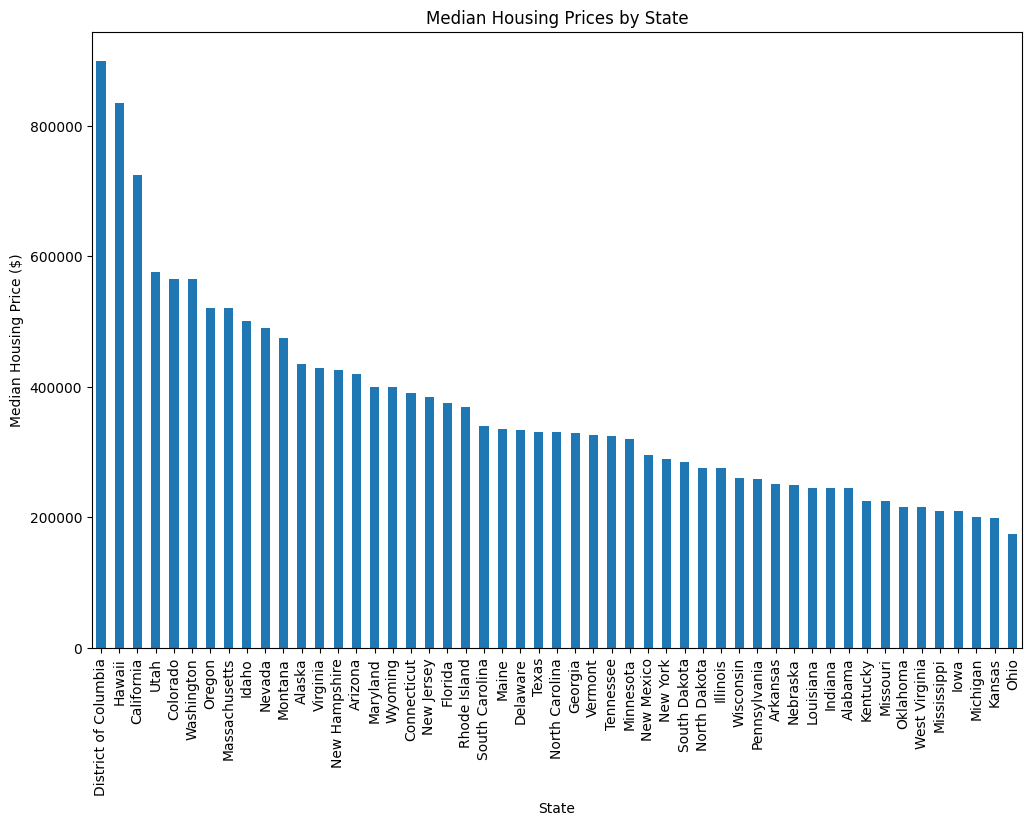

In [ ]:
# What is the distribution of housing prices across different states, and which state has the highest median housing price?
median_prices = realestate.groupby('state')['price'].median().sort_values(ascending=False)

plt.figure(figsize=(30, 18))
median_prices.plot(kind='bar', figsize=(12, 8), title='Median Housing Prices by State')
plt.xlabel('State')
plt.ylabel('Median Housing Price ($)')
plt.show()

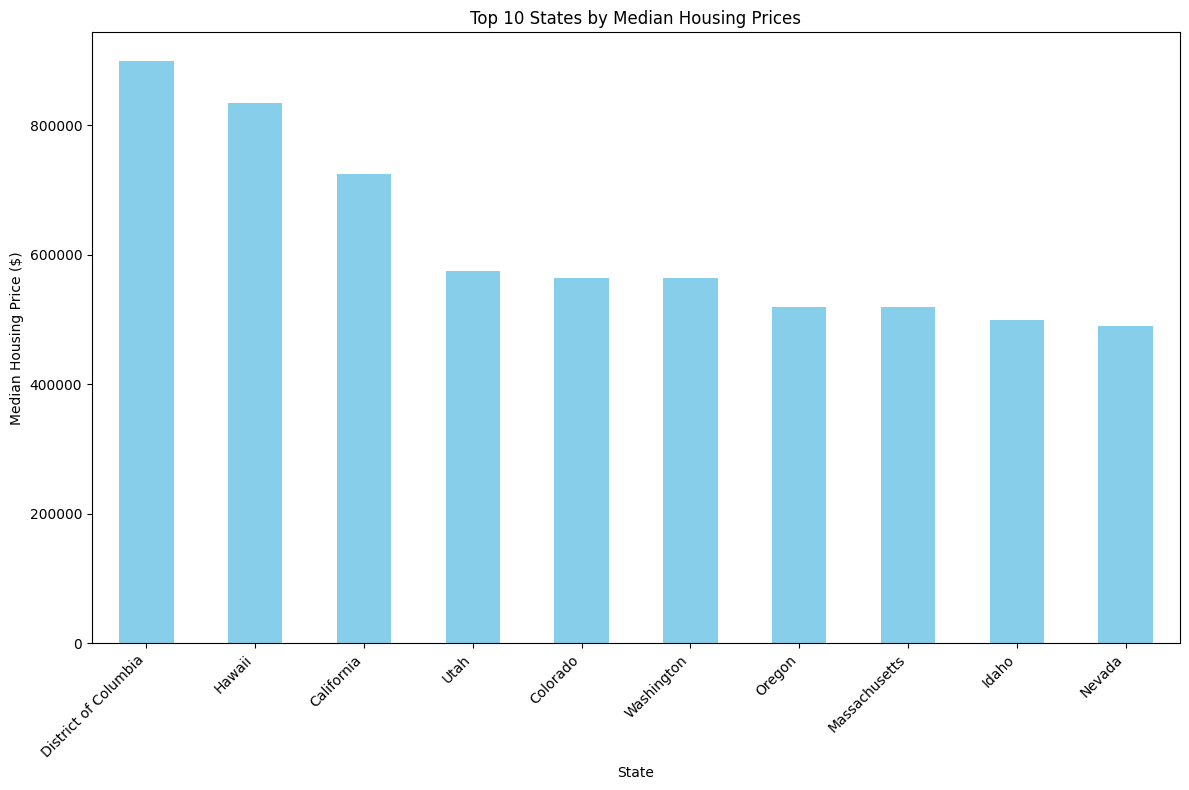

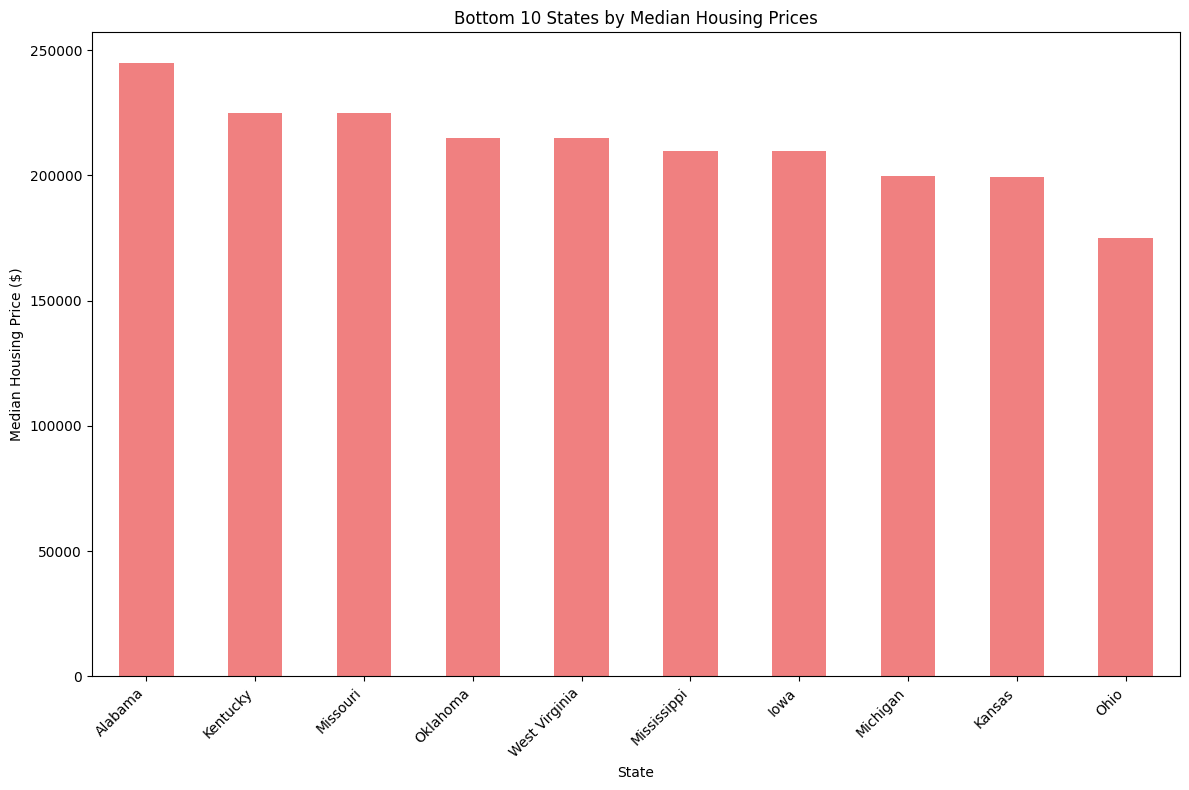

In [ ]:
# Slice the top 10 and bottom 10 states
top_10_states = median_prices.head(10)
bottom_10_states = median_prices.tail(10)

# Plot the top 10 states
plt.figure(figsize=(12, 8))
top_10_states.plot(kind='bar', color='skyblue', title='Top 10 States by Median Housing Prices')
plt.xlabel('State')
plt.ylabel('Median Housing Price ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the bottom 10 states
plt.figure(figsize=(12, 8))
bottom_10_states.plot(kind='bar', color='lightcoral', title='Bottom 10 States by Median Housing Prices')
plt.xlabel('State')
plt.ylabel('Median Housing Price ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
#which cities have biggest median house size and which ones have smallest?

median_house_size_by_city_state = realestate.groupby(['city', 'state'])['house_size'].median()

city_biggest_med_size = median_house_size_by_city_state.sort_values(ascending=False)
city_smallest_med_size = median_house_size_by_city_state.sort_values(ascending=True)

print("Cities with biggest median house size:")
print(city_biggest_med_size.head())

print("\nCities with smallest median house size:")
print(city_smallest_med_size.head())


Cities with biggest median house size:
city              state     
Stephensville     Louisiana     32920.0
Cresskill         New Jersey    19110.0
Highland          Arkansas      16480.0
Rochdale Village  New York      15000.0
Cleora            Oklahoma      15000.0
Name: house_size, dtype: float64

Cities with smallest median house size:
city              state     
Butte Meadows     California    200.0
Jasper            Arkansas      240.0
Fish Lake         Minnesota     300.0
South Lake Tahoe  Nevada        384.0
Clam Lake         Wisconsin     384.0
Name: house_size, dtype: float64


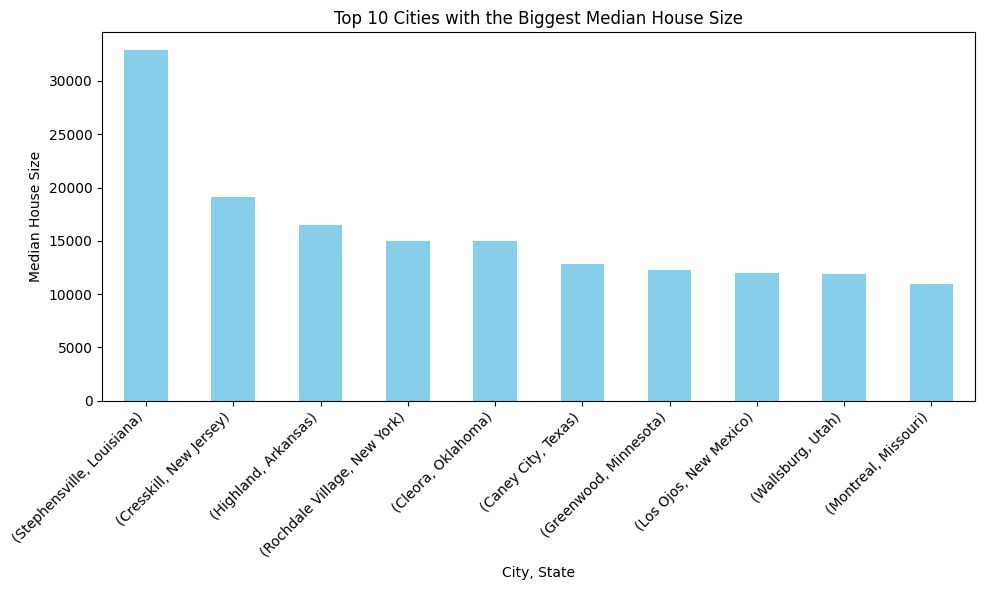

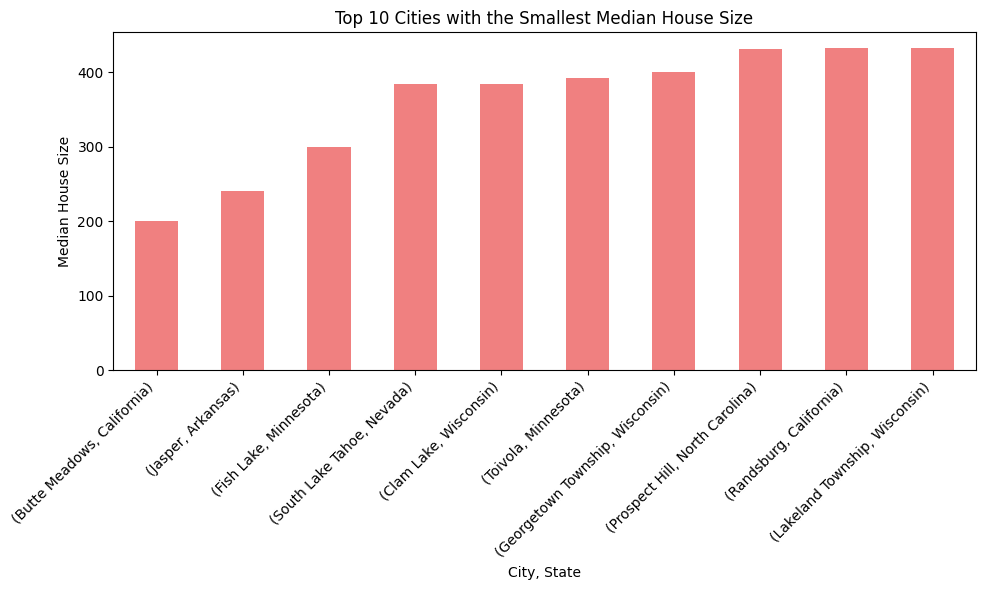

In [ ]:
import matplotlib.pyplot as plt

# Plot the cities with the biggest median house size
plt.figure(figsize=(10, 6))
city_biggest_med_size.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Cities with the Biggest Median House Size')
plt.xlabel('City, State')
plt.ylabel('Median House Size')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the cities with the smallest median house size
plt.figure(figsize=(10, 6))
city_smallest_med_size.head(10).plot(kind='bar', color='lightcoral')
plt.title('Top 10 Cities with the Smallest Median House Size')
plt.xlabel('City, State')
plt.ylabel('Median House Size')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


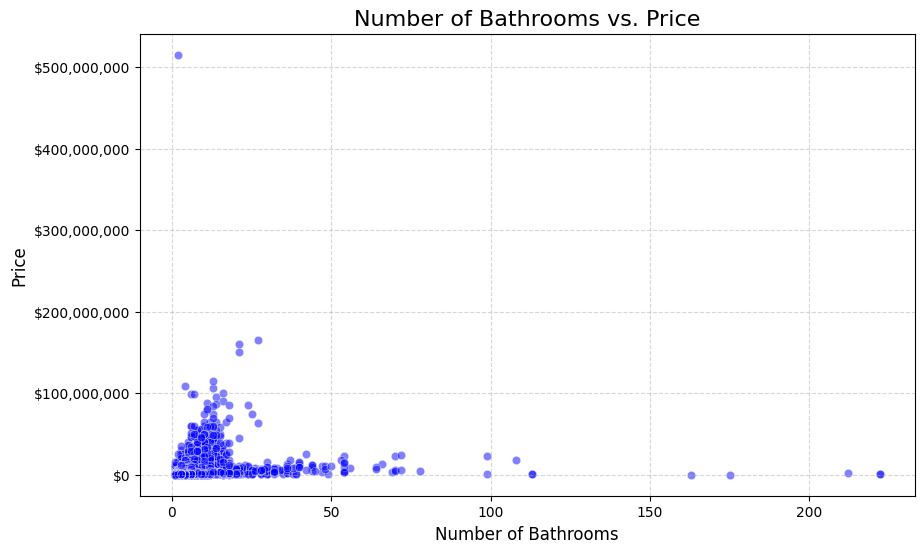

In [ ]:
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
sns.scatterplot(data=realestate, x='bath', y='price', color='blue', alpha=0.5)
plt.title('Number of Bathrooms vs. Price', fontsize=16)
plt.xlabel('Number of Bathrooms', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

formatter = ticker.StrMethodFormatter('${x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

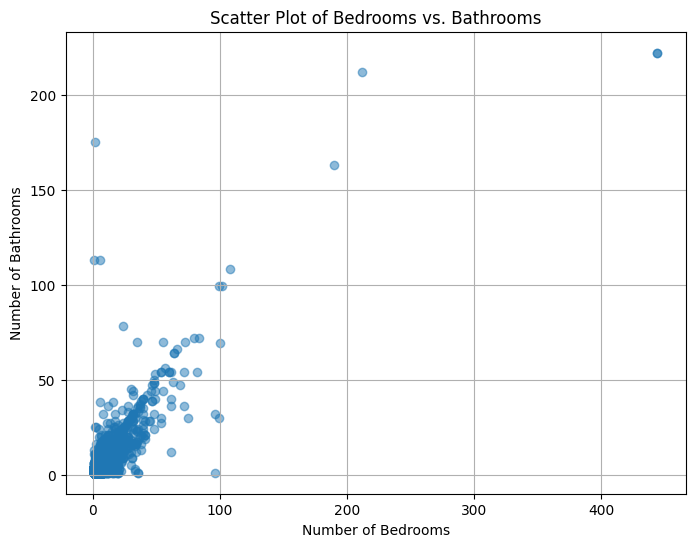

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(realestate['bed'], realestate['bath'], alpha=0.5)
plt.title('Scatter Plot of Bedrooms vs. Bathrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Number of Bathrooms')
plt.grid(True)
plt.show()

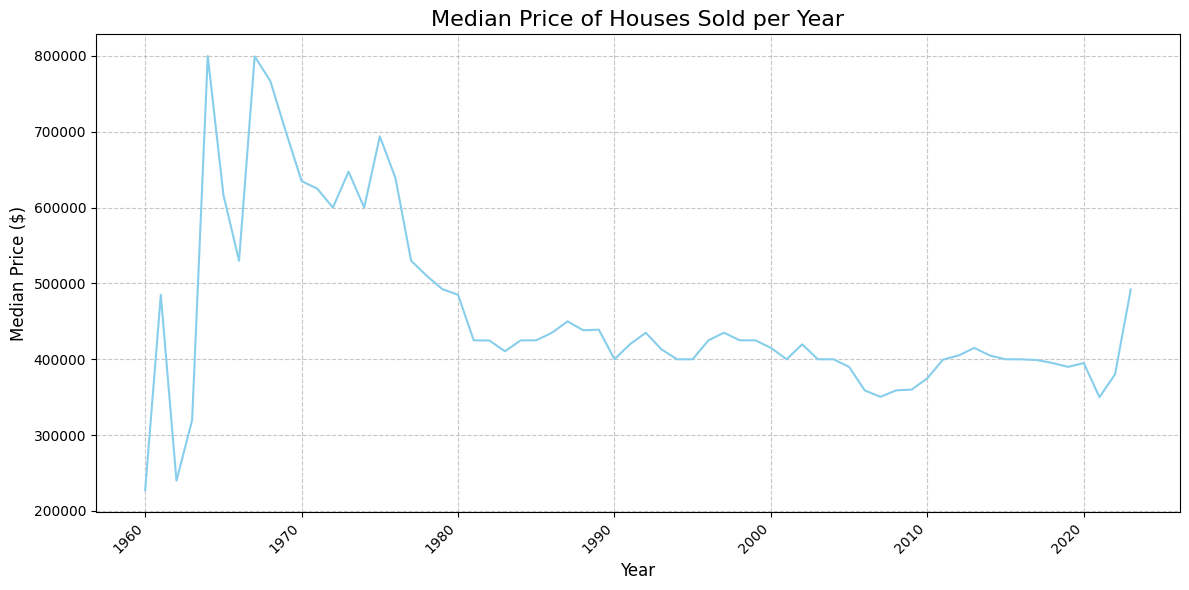

In [ ]:
#start from 1960 bc the previous years seem to not have as much data and be skewed
realestate_filtered = realestate[realestate['prev_sold_date'].dt.year >= 1960]

median_price_by_year = realestate_filtered.groupby(realestate_filtered['prev_sold_date'].dt.year)['price'].median()

plt.figure(figsize=(12, 6))
median_price_by_year.plot(kind='line', marker='', color='skyblue')
plt.title('Median Price of Houses Sold per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
#make note - not adjusted for inflation

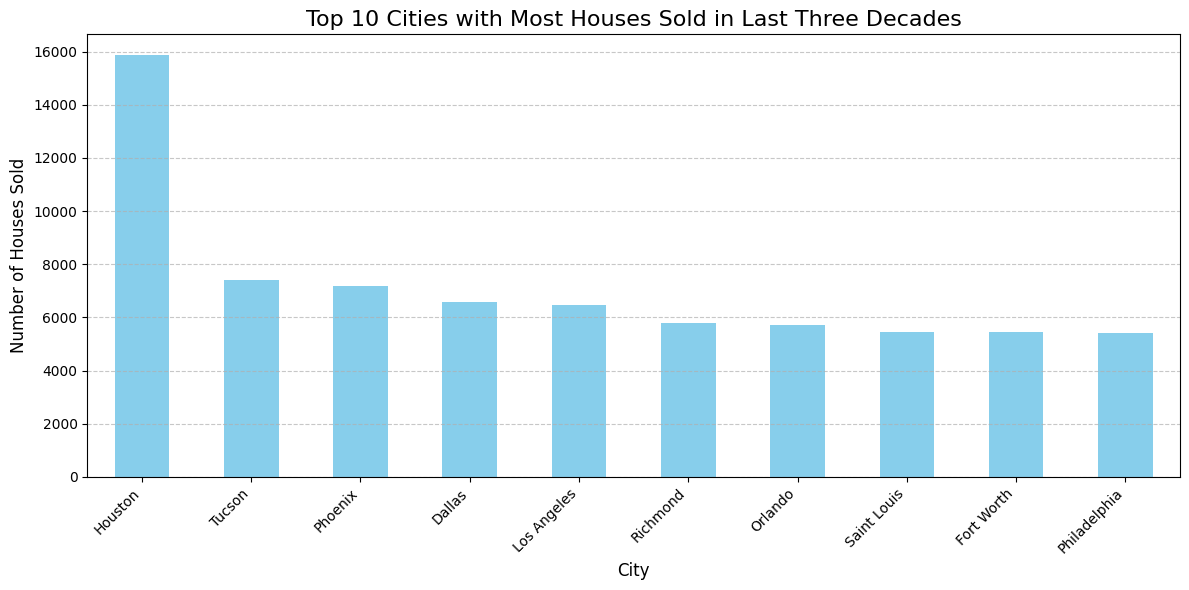

In [ ]:
#what cities are people moving to?
#to find this, find the top 10 cities with the most number of houses sold in the last 3 decades
filtered_data = realestate[realestate['prev_sold_date'].dt.year >= 1994]

houses_sold_by_city = filtered_data.groupby('city').size()

top_10_cities_most_sold = houses_sold_by_city.nlargest(10)

plt.figure(figsize=(12, 6))
top_10_cities_most_sold.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cities with Most Houses Sold in Last Three Decades', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Houses Sold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

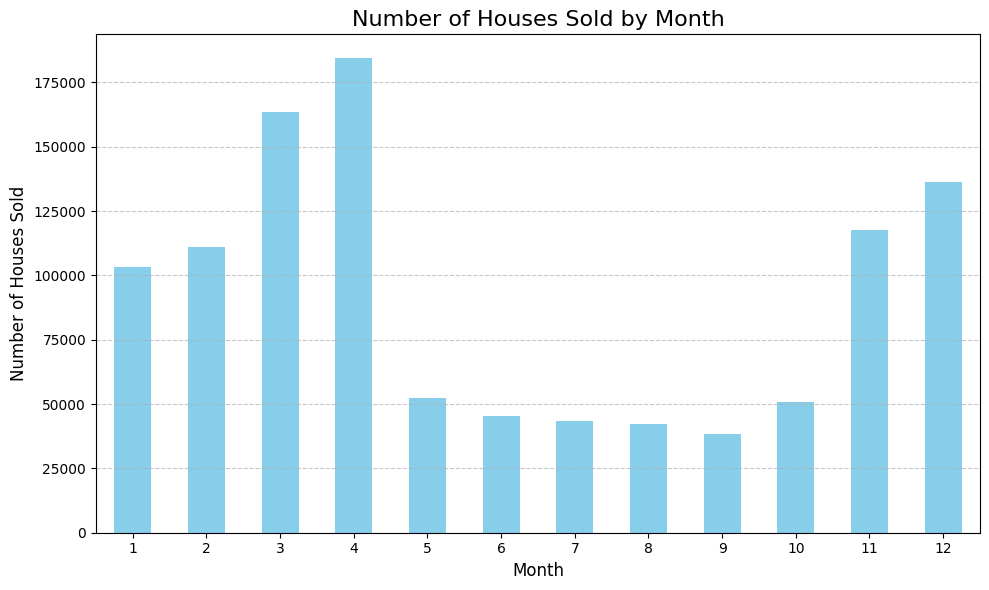

In [ ]:
#are there months that there are more/less houses sold?
houses_sold_by_month = realestate.groupby(realestate['prev_sold_date'].dt.month)['price'].count()

plt.figure(figsize=(10, 6))
houses_sold_by_month.plot(kind='bar', color='skyblue')
plt.title('Number of Houses Sold by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Houses Sold', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

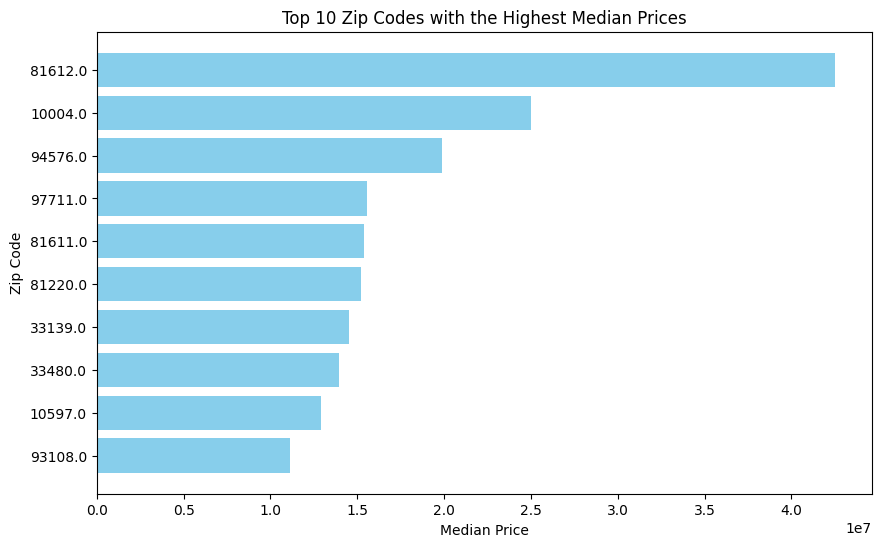

In [ ]:
zip_median_prices = realestate.groupby('zip_code')['price'].median().reset_index()

zip_median_prices_sorted = zip_median_prices.sort_values(by='price', ascending=False)

top_zip_codes = zip_median_prices_sorted.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_zip_codes['zip_code'].astype(str), top_zip_codes['price'], color='skyblue')
plt.xlabel('Median Price')
plt.ylabel('Zip Code')
plt.title('Top 10 Zip Codes with the Highest Median Prices')
plt.gca().invert_yaxis()
plt.show()


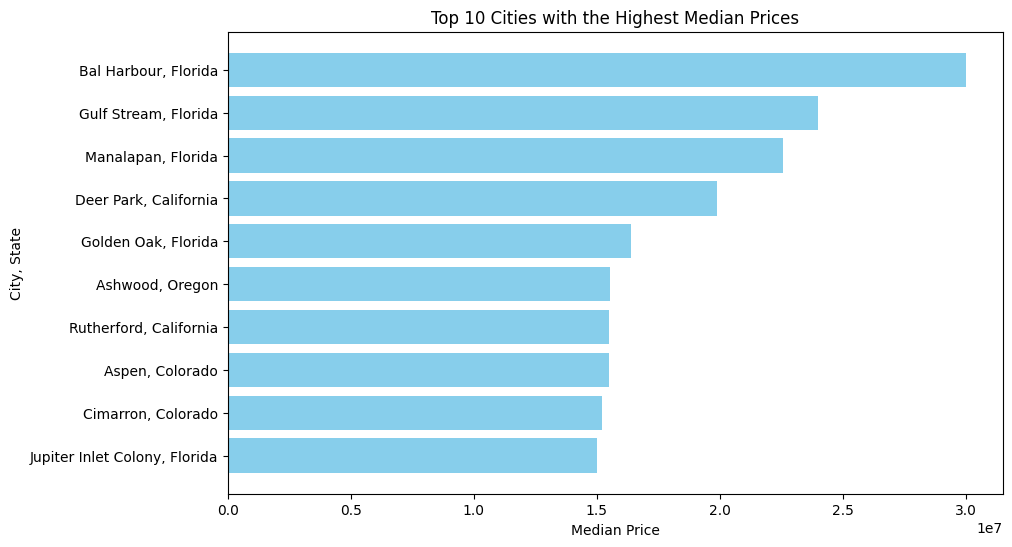

In [ ]:
city_median_prices = realestate.groupby(['state', 'city'])['price'].median().reset_index()

city_median_prices_sorted = city_median_prices.sort_values(by='price', ascending=False)

top_cities = city_median_prices_sorted.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_cities['city'] + ', ' + top_cities['state'], top_cities['price'], color='skyblue')
plt.xlabel('Median Price')
plt.ylabel('City, State')
plt.title('Top 10 Cities with the Highest Median Prices')
plt.gca().invert_yaxis()
plt.show()


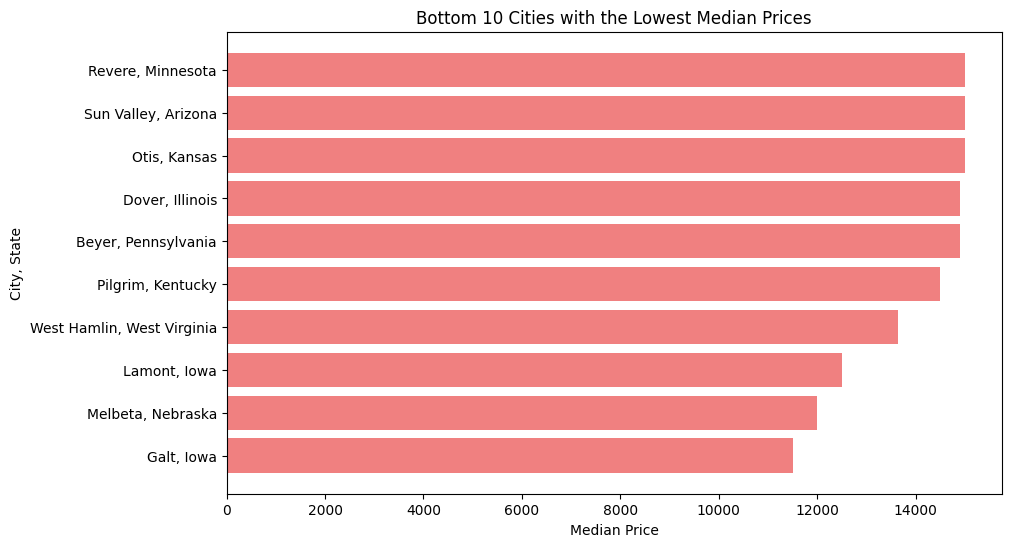

In [ ]:
# Get the bottom 10 cities
bottom_cities = city_median_prices_sorted.tail(10)
plt.figure(figsize=(10, 6))
plt.barh(bottom_cities['city'] + ', ' + bottom_cities['state'], bottom_cities['price'], color='lightcoral')
plt.xlabel('Median Price')
plt.ylabel('City, State')
plt.title('Bottom 10 Cities with the Lowest Median Prices')
plt.gca().invert_yaxis()
plt.show()

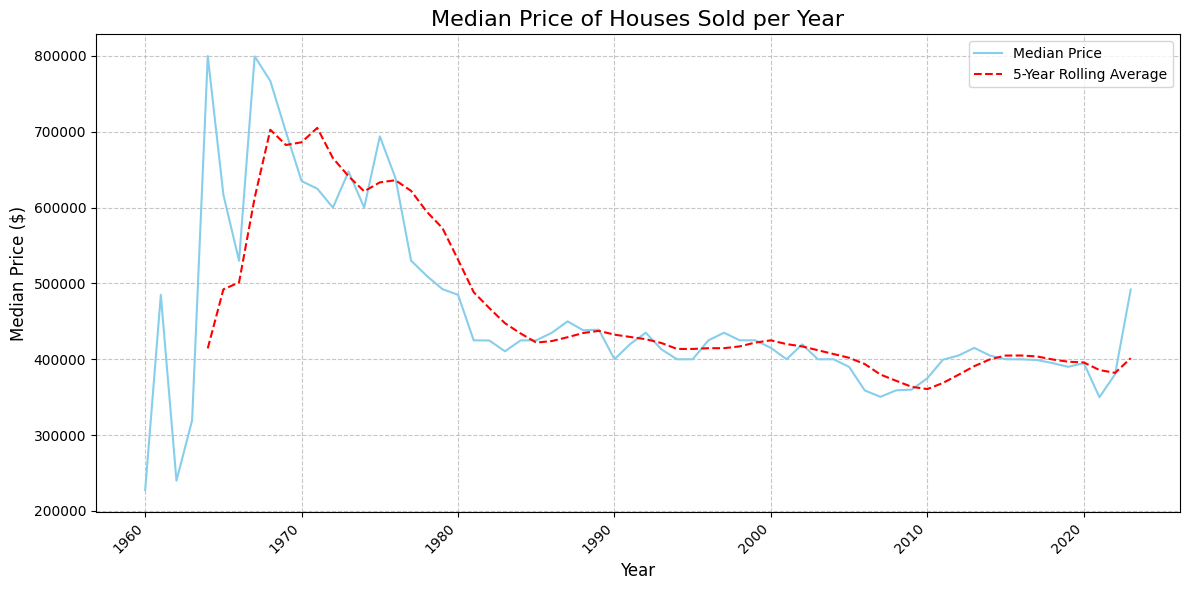

In [ ]:
realestate_filtered = realestate[realestate['prev_sold_date'].dt.year >= 1960]

# Group by year and calculate median price
median_price_by_year = realestate_filtered.groupby(realestate_filtered['prev_sold_date'].dt.year)['price'].median()

# Calculate rolling average
rolling_avg = median_price_by_year.rolling(window=5).mean()  # Adjust the window size as needed

# Plot median price
plt.figure(figsize=(12, 6))
median_price_by_year.plot(kind='line', marker='', color='skyblue', label='Median Price')
rolling_avg.plot(kind='line', marker='', color='red', linestyle='--', label='5-Year Rolling Average')  # Add rolling average line
plt.title('Median Price of Houses Sold per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


Plotting Numbers on Map

In [ ]:
state_abbr = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'District of Columbia': 'DC'
}

In [ ]:
realestatedf2 = pd.read_csv("realtor-data.zip.csv")

In [ ]:
realestatedf2.head()


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [ ]:
sampledf = realestatedf2[['city', 'state', 'house_size', 'price', 'acre_lot']]

In [ ]:
sampledf['state_abbr'] = sampledf['state'].map(state_abbr)

<ipython-input-114-c00fc6f9f987>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.graph_objects as go

average_price_by_state = sampledf.groupby('state_abbr')['price'].mean().reset_index()

fig = go.Figure(data=go.Choropleth(
    locations=average_price_by_state['state_abbr'],
    z=average_price_by_state['price'],
    locationmode='USA-states',
    colorscale='Hot',
    colorbar_title='Average Price (USD)',
))

fig.update_layout(
    title_text='Average House Price by State',
    geo=dict(
        scope='usa',
        showlakes=True,
        lakecolor='rgb(255, 255, 255)',
    )
)
fig.show()

In [ ]:
grouped = sampledf.groupby('state_abbr')

# Calculate rate of increase for each state
rates_of_increase = {}
for state, group in grouped:
    if len(group) > 1:
        previous_price = group['price'].iloc[0]
        current_price = group['price'].iloc[-1]
        rate_of_increase = ((current_price - previous_price) / previous_price) * 100
        rates_of_increase[state] = rate_of_increase

# Convert rates_of_increase to DataFrame for easier visualization
rates_df = pd.DataFrame(rates_of_increase.items(), columns=['State', 'Rate_of_increase'])

print(rates_df)


In [ ]:
rates_df.head()

In [ ]:
import plotly.express as px

fig = px.line(rates_df, x='State', y="Rate_of_increase")
fig.show()

In [ ]:
import sqlite3
import csv

In [ ]:
# loading datafiles
realestatedf2.columns = realestatedf2.columns.str.strip()

#connect to db
conn = sqlite3.connect('realestatedb')

#load file to sql
realestatedf2.to_sql('realestate', conn, if_exists='replace')
conn.close()

In [ ]:
conn = sqlite3.connect('realestatedb')
cur = conn.cursor()

In [ ]:
query = '''
    SELECT state, AVG(price) AS avg_price
    FROM realestate
    GROUP BY state
    ORDER BY avg_price DESC
'''

In [ ]:
avghouse = cur.execute(query).fetchall()
print(avghouse)

[('Hawaii', 1240095.2950434904), ('California', 1029223.6994084038), ('New York', 943796.8240642904), ('District of Columbia', 882849.7797735849), ('Utah', 881418.403091721), ('Colorado', 832179.2800582421), ('Montana', 792043.2381946516), ('Virgin Islands', 759440.0502793296), ('Massachusetts', 724824.7054493836), ('Guam', 713861.6625766872), ('Nevada', 673701.8525641026), ('Connecticut', 670580.2711307824), ('Idaho', 660400.9888418163), ('Washington', 658766.4877197477), ('Puerto Rico', 640685.7523992322), ('Wyoming', 612671.4079306072), ('Oregon', 586858.9441818522), ('New Jersey', 569924.4849327578), ('Florida', 548206.7871767875), ('Arizona', 485951.36467725976), ('New Hampshire', 481941.0002745744), ('Rhode Island', 481324.2120877774), ('Virginia', 468093.67651207774), ('Maryland', 456430.52182315645), ('Vermont', 444875.0646153846), ('Texas', 441399.12853623746), ('Delaware', 433580.49947826087), ('Georgia', 390382.8568746835), ('South Carolina', 387418.7118663861), ('Tennessee'

In [ ]:
for state, price in avghouse:
    formatted_price = '${:,.2f}'.format(price)
    print(f'{state}: {formatted_price}')

Hawaii: $1,240,095.30
California: $1,029,223.70
New York: $943,796.82
District of Columbia: $882,849.78
Utah: $881,418.40
Colorado: $832,179.28
Montana: $792,043.24
Virgin Islands: $759,440.05
Massachusetts: $724,824.71
Guam: $713,861.66
Nevada: $673,701.85
Connecticut: $670,580.27
Idaho: $660,400.99
Washington: $658,766.49
Puerto Rico: $640,685.75
Wyoming: $612,671.41
Oregon: $586,858.94
New Jersey: $569,924.48
Florida: $548,206.79
Arizona: $485,951.36
New Hampshire: $481,941.00
Rhode Island: $481,324.21
Virginia: $468,093.68
Maryland: $456,430.52
Vermont: $444,875.06
Texas: $441,399.13
Delaware: $433,580.50
Georgia: $390,382.86
South Carolina: $387,418.71
Tennessee: $377,167.02
Minnesota: $366,313.72
Kansas: $361,726.57
South Dakota: $360,786.37
Illinois: $349,957.60
North Carolina: $335,128.82
Maine: $333,854.80
Pennsylvania: $331,961.16
New Mexico: $323,991.71
Alabama: $303,565.74
Alaska: $300,451.39
Nebraska: $298,352.66
Indiana: $292,582.76
Missouri: $288,089.50
Louisiana: $286,6

In [ ]:
query = """
SELECT state, COUNT(*) AS soldhouses
FROM realestate
WHERE prev_sold_date >= DATE('now', '-30 years')  -- Filter for sales within the last 30 years
GROUP BY state
ORDER BY soldhouses DESC
LIMIT 10;
"""

In [ ]:
soldhouses = cur.execute(query).fetchall()
print(soldhouses)

[('Florida', 189050), ('California', 185362), ('Texas', 123132), ('New York', 65628), ('Illinois', 61643), ('Georgia', 57531), ('Arizona', 56322), ('Pennsylvania', 51366), ('Washington', 49649), ('Virginia', 48572)]


In [ ]:
for state, count in soldhouses:
    print(f'{state}: {count} houses sold.')

Florida: 189050 houses sold.
California: 185362 houses sold.
Texas: 123132 houses sold.
New York: 65628 houses sold.
Illinois: 61643 houses sold.
Georgia: 57531 houses sold.
Arizona: 56322 houses sold.
Pennsylvania: 51366 houses sold.
Washington: 49649 houses sold.
Virginia: 48572 houses sold.


In [ ]:
conn.close()